In [5]:
from coare35vn import *
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
dirLoc = '/vortexfs1/share/seolab/srai/observation/'

ds_WIND = Dataset(dirLoc + 'SatelliteVsBuoy/downloads/Buoy/mergedTAO_Bouy2000/T0N140W_2000.nc')
ds_SST = Dataset(dirLoc + 'SatelliteVsBuoy/downloads/Buoy/mergedTAO_Bouy2000/TAO_T0N140W_SST_2000.nc')
ds_AIRT = Dataset(dirLoc + 'SatelliteVsBuoy/downloads/Buoy/mergedTAO_Bouy2000/TAO_T0N140W_AIRT_2000.nc')
ds_RH = Dataset(dirLoc + 'SatelliteVsBuoy/downloads/Buoy/mergedTAO_Bouy2000/TAO_T0N140W_RH_2000.nc')

cdfTime = ds_WIND.variables['TIME']
timeUnit = cdfTime.units
timeArr = np.array(cdfTime)
cftimes=num2date(timeArr, timeUnit)
wind_dateTimeArr = [datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes]


cdfTime = ds_RH.variables['TIME']
timeUnit = cdfTime.units
timeArr = np.array(cdfTime)
cftimes=num2date(timeArr, timeUnit)
rh_dateTimeArr = [datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes]

cdfTime = ds_SST.variables['TIME']
timeUnit = cdfTime.units
timeArr = np.array(cdfTime)
cftimes=num2date(timeArr, timeUnit)
sst_dateTimeArr = [datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes]


cdfTime = ds_AIRT.variables['TIME']
timeUnit = cdfTime.units
timeArr = np.array(cdfTime)
cftimes=num2date(timeArr, timeUnit)
airt_dateTimeArr = [datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes]



speed = np.array(ds_WIND.variables['WSPD'])
uspeed = np.array(ds_WIND.variables['UWND'])
vspeed = np.array(ds_WIND.variables['VWND'])
rh = np.array(ds_RH.variables['RELH'])
sst = np.array(ds_SST.variables['SST'])
airt = np.array(ds_AIRT.variables['AIRT'])

################################ 10 min time grid ##################################33
timeList = []

deltaT = timedelta(minutes=10)
starttime = datetime(2000, 1, 1, 0, 0)
endtime = datetime(2001, 1, 1, 0, 0)
curtime = starttime

while curtime <= endtime:
    timeList.append(curtime)
    curtime+=deltaT
    
nanArr = np.ones(len(timeList), dtype=float)

############################## Fill Void Data ##########################################


def fillData(date1, date2, arr1, arr2):
    
    len1 = len(date1)
    len2 = len(date2)
    
    loop = True
    
    i = 0
    j = 0
    
    while loop:
        if date1[i] < date2[j]:
            #print(1)
            #print('date1 ', date1[i], '\n date2', date2[j], '\n i,j',i,j)
            
            dateval = date1[i]
            arrval = float('nan')
            
            index = j
            date2.insert(index, dateval)
            arr2 = np.insert(arr2, index, arrval)
            
            #print('after adding in date2')
            #print('date1 ', date1[i], '\n date2', date2[j], '\n i,j',i,j, '\n')
            
        elif date1[i] > date2[j]:
            #print(2)
            #print('date1', date1[i], '\n date2', date2[j], '\n i,j',i,j)
            
            dateval = date2[j]
            arrval = float('nan')
            
            index = i
            date1.insert(index, dateval)
            arr1 = np.insert(arr1, index, arrval)
            
            #print('after adding in date1')
            #print('date1 ', date1[i], '\n date2', date2[j], '\n i,j',i,j, '\n')
            
        else:
            i+=1
            j+=1
            
            
        if j >= len(date2)-1:
            print('ending', i, j, date1[i-1], date2[j-1])
            loop = False
            
        
        
    return date1, date2, arr1, arr2

wind_dateTimeArr1 = wind_dateTimeArr.copy()
wind_dateTimeArr2 = wind_dateTimeArr.copy()
wind_dateTimeArr3 = wind_dateTimeArr.copy()

wind_dateTimeArr1, timeList, uspeed, nanArr = fillData(wind_dateTimeArr1, timeList, uspeed, nanArr)
wind_dateTimeArr2, timeList, vspeed, nanArr = fillData(wind_dateTimeArr2, timeList, vspeed, nanArr)
wind_dateTimeArr3, timeList, speed, nanArr = fillData(wind_dateTimeArr3, timeList, speed, nanArr)
rh_dateTimeArr, timeList, rh, nanArr = fillData(rh_dateTimeArr, timeList, rh, nanArr)
sst_dateTimeArr, timeList, sst, nanArr = fillData(sst_dateTimeArr, timeList, sst, nanArr)
airt_dateTimeArr, timeList, airt, nanArr = fillData(airt_dateTimeArr, timeList, airt, nanArr)


###################################### Coare Output ##########################################

coareOutPutArr = coare35vn(speed, airt, rh, sst, zu=4.0)
negU  = uspeed < 0.0
negV  = vspeed < 0.0

coareOutPutArrU = coare35vn(abs(uspeed), airt, rh, sst, zu=4.0)
coareOutPutArrV = coare35vn(abs(vspeed), airt, rh, sst, zu=4.0)

coareOutPutArrU[:, negU] *=-1 
coareOutPutArrV[:, negV] *=-1 

#print(coareOutPutArr.shape)
U10N = coareOutPutArr[0,:]
u10 = coareOutPutArr[1,:]

U10N_x = coareOutPutArrU[0,:]
u10_x = coareOutPutArrU[1,:]

U10N_y = coareOutPutArrV[0,:]
u10_y = coareOutPutArrV[1,:]

#################################### Angle ####################################################

angleOrig = np.rad2deg(np.arctan2(vspeed,uspeed))
angleU10N = np.rad2deg(np.arctan2(U10N_y,U10N_x))
angleU10 = np.rad2deg(np.arctan2(u10_y,u10_x))

angleOrig[angleOrig < 0] += 360
angleU10N[angleU10N < 0] += 360
angleU10[angleU10 < 0] += 360


ending 52704 52704 2000-12-31 23:50:00 2000-12-31 23:50:00
ending 52704 52704 2000-12-31 23:50:00 2000-12-31 23:50:00
ending 52704 52704 2000-12-31 23:50:00 2000-12-31 23:50:00
ending 52704 52704 2000-12-31 23:50:00 2000-12-31 23:50:00
ending 52704 52704 2000-12-31 23:50:00 2000-12-31 23:50:00
ending 52704 52704 2000-12-31 23:50:00 2000-12-31 23:50:00


In [52]:
folder = '/vortexfs1/share/seolab/srai/observation/SatelliteVsBuoy/COARE3p5/COAREalgorithm/Python/COARE3p5/data/'
qds = Dataset(folder + 'QuikSCAT_2000_01_03_T03.04.11_to_2000_12_31_T15.08.00.nc')

qstime = np.array(qds.variables['time'])
qstimeUnits = qds.variables['time'].units
cftimes = num2date(qstime, qstimeUnits)
qs_dateTimeArr = [datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes]

qs_wspd = np.array(qds.variables['wspd'])
qs_wdir = np.array(qds.variables['wdir'])

qs_wspd[abs(qs_wspd)>1000] = float('nan')
qs_wdir[abs(qs_wspd)>1000] = float('nan')

qs_wspd[abs(qs_wdir)>1000] = float('nan')
qs_wdir[abs(qs_wdir)>1000] = float('nan')


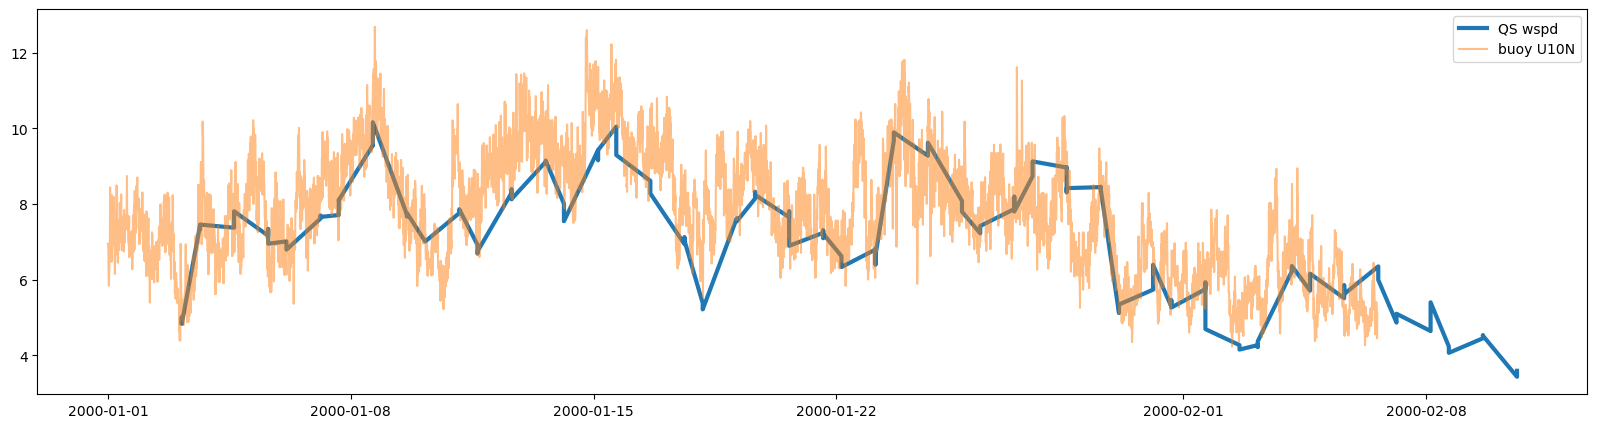

In [68]:
st1 = 0
ed1 = int(len(speed)//10)

st2 = 0
ed2 = int(len(qs_wspd)//10)

plt.figure(figsize=(20,5))

#plt.plot(wind_dateTimeArr1[st1:ed1], speed[st1:ed1], label = 'buoy wspd', alpha = 0.5)
plt.plot(qs_dateTimeArr[st2:ed2], qs_wspd[st2:ed2], label = 'QS wspd', linewidth=3) #color = 'r', s = 3, marker = 'x', 
plt.plot(wind_dateTimeArr1[st1:ed1], U10N[st1:ed1], label = 'buoy U10N', alpha = 0.5)
plt.legend()

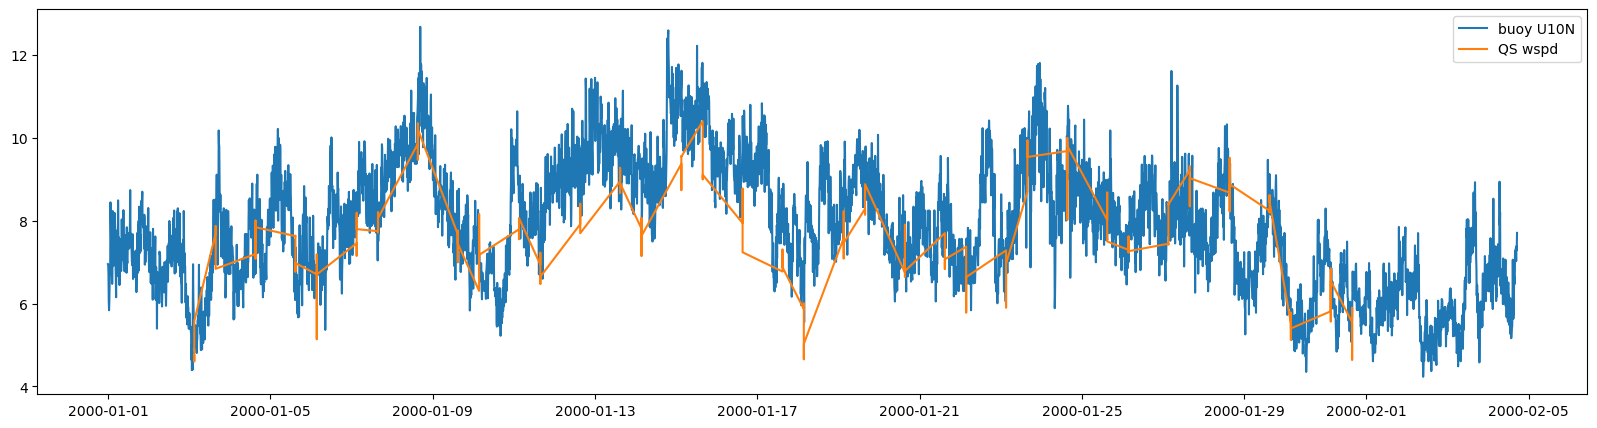

In [24]:
st1 = 0
ed1 = 5000

st2 = 0
ed2 = len(qs_wspd)

plt.figure(figsize=(20,5))

plt.plot(wind_dateTimeArr1[st1:ed1], U10N[st1:ed1], label = 'buoy U10N')
plt.plot(qs_dateTimeArr[st2:ed2], qs_wspd[st2:ed2], label = 'QS wspd')
plt.legend()

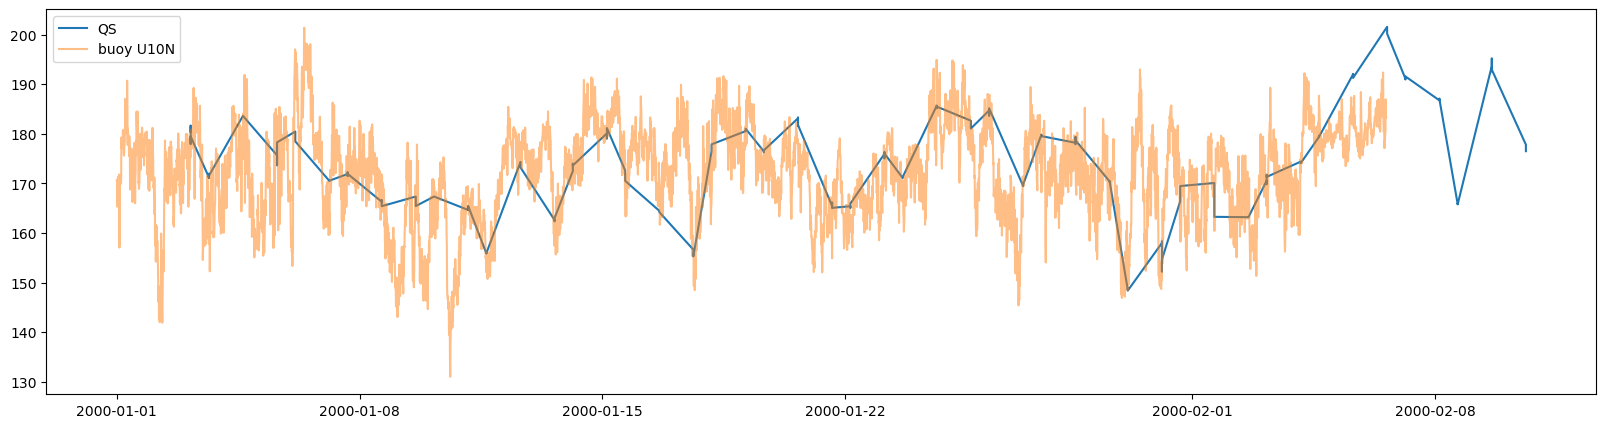

In [72]:
st1 = 0
ed1 = int(len(speed)//10)

st2 = 0
ed2 = int(len(qs_wspd)//10)

plt.figure(figsize=(20,5))

#plt.plot(wind_dateTimeArr1[st1:ed1], angleOrig[st1:ed1], label = 'buoy')
plt.plot(qs_dateTimeArr[st2:ed2], (-qs_wdir[st2:ed2]+360+90), label = 'QS')
plt.plot(wind_dateTimeArr1[st1:ed1], angleU10N[st1:ed1], label = 'buoy U10N', alpha=0.5)
plt.legend()

In [2]:
import numpy as np
a= np.array([])

In [3]:
a

array([], dtype=float64)

In [4]:
np.mean(a)

/vortexfs1/home/shikhar.rai/.conda/envs/mpiNetCDF/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/vortexfs1/home/shikhar.rai/.conda/envs/mpiNetCDF/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan